In [1]:
# Global imports and settings
from __future__ import print_function
from __future__ import division

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (7, 7)

import numpy as np
np.set_printoptions(precision=3)

<center>
    <img src="img/scikit-learn-logo.png" width="40%" />
    <br />
    <h1>An introduction to Machine Learning with Scikit-Learn</h1>
    <br /><br />
    Gilles Louppe (<a href="https://twitter.com/glouppe">@glouppe</a>), April 23, 2015
    <br /><br />
    Materials at <a href="https://github.com/glouppe/tutorial-sklearn-lhcb">https://github.com/glouppe/tutorial-sklearn-lhcb</a>
</center>

# About myself 

* PhD in machine learning, expertise in tree-based methods
* Core developer of Scikit-Learn
* Research Fellow working in GS-SIS, on graph and text mining problems
* Open to collaborations

# Outline

* What is machine learning?
* Scikit-Learn
* Classifying events with decision trees
* Model evaluation and selection
* Ensemble methods
* Model persistence
* Going further

# What is machine learning?

Predict, understand or identify patterns in data from observations.

Applications include: _Natural language processing, Computer vision, IR and advertisement, Robotics, Bioinformatics, __High Energy Physics__, ..._

<center><img src="img/motivation.png" width="70%" /></center>

# Scikit-Learn

## Overview

* Machine learning library written in __Python__
* __Simple and efficient__, for both experts and non-experts
* Classical, __well-established machine learning algorithms__
* Shipped with <a href="http://scikit-learn.org/dev/documentation.html">documentation</a> and <a href="http://scikit-learn.org/dev/auto_examples/index.html">examples</a>
* __BSD 3 license__

## Community driven development

- 10-15~ core developers (mostly researchers)
- 250+ occasional contributors
- __All working together__ on [GitHub](https://github.com/scikit-learn/scikit-learn)
- Emphasis on __keeping the project maintainable__
    - Style consistency
    - Unit-test coverage
    - Documentation and examples
    - Code review

## Python stack for data analysis

- The __open source__ Python ecosystem provides __a standalone, versatile and powerful scientific working environment__, including: [NumPy](http://numpy.org), [SciPy](http://scipy.org), [IPython](http://ipython.org), [Matplotlib](http://matplotlib.org), [Pandas](http://pandas.pydata.org/), _and many others..._
- Core algorithms are implemented in low-level languages;
- Scikit-Learn builds upon NumPy and SciPy and __complements__ this scientific environment with machine learning algorithms;
- By design, Scikit-Learn is __non-intrusive__, easy to use and easy to combine with other libraries.

<center> 
<img src="img/scikit-learn-logo.png" style="max-width: 120px; display: inline" />
<img src="img/numpy-logo.png" style="max-width: 120px; display: inline" />
<img src="img/scipy-logo.png" style="max-width: 120px; display: inline" />
<img src="img/ipython-logo.jpg" style="max-width: 120px; display: inline" />
<img src="img/matplotlib-logo.png" style="max-width: 120px; display: inline"/>
<img src="img/pandas-logo.png" style="max-width: 120px; display: inline" />
</center>

## Algorithms

__Supervised learning:__

* Linear models (Ridge, Lasso, Elastic Net, ...)
* Ensemble methods (Random Forests, Bagging, GBRT, ...)
* Support Vector Machines
* Nearest neighbors
* Neural networks (soon!)

<center><img src="img/classifiers.png" />
<em>A comparison of (some of the) classifiers in Scikit-Learn</em></center><br />

__Unsupervised learning:__

* Clustering (KMeans, Ward, ...)
* Matrix decomposition (PCA, ICA, ...)
* Density estimation
* Outlier detection

__Model selection and evaluation:__

* Cross-validation
* Grid-search
* Lots of metrics

_... and many more!_ (See our [Reference](http://scikit-learn.org/stable/modules/classes.html))

# Classifying events with decision trees

## Supervised learning framework

- Data comes as a finite learning set ${\cal L} = (X, y)$ where
    * Input samples are given as an array $X$ of shape `n_samples` $\times$ `n_features` <br />
      E.g. samples are events and features are their kinematic properties
        
    * Output values are given as an array $y$ <br />
      E.g. whether the event is background or signal
    
- The goal is to build an estimator $\varphi_{\cal L}: {\cal X} \mapsto {\cal Y}$ minimizing
    $$
    Err(\varphi_{\cal L}) = \mathbb{E}_{X,Y}\{ L(Y, \varphi_{\cal L}(X)) \}.
    $$

## Loading data

In [2]:
# Download data from https://archive.ics.uci.edu/ml/datasets/SUSY

# Load CSV file with pandas
import pandas as pd 
df = pd.read_csv("SUSY.csv", header=None)     
df.columns = [# 0 = background, 1 = signal
              "target", 
              # Kinematic properties
              "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", 
              "lepton 2 pT", "lepton 2 eta", "lepton 2 phi", 
              "missing energy magnitude", "missing energy phi", 
              # Derived features
              "MET_rel","axial MET", "M_R", "M_TR_2", "R", "MT2", 
              "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]
df.target = df.target.astype(int)

Note: for importing ROOT data in Python, see the <a href="http://www.rootpy.org/">rootpy</a> project.

## Exploration and visualization with `pandas`

In [22]:
df.head()  # df.describe(), df.info(), ...

,target,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


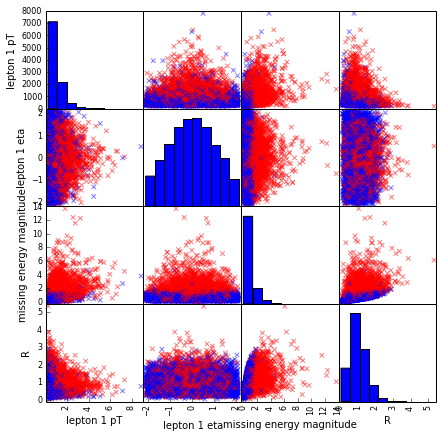

In [3]:
df_sample = df[:10000]
colors = ["blue", "red"]   # blue = background, red = signal
features = ["lepton 1 pT", "lepton 1 eta", "missing energy magnitude", "R"]

_ = pd.scatter_matrix(df_sample[features], marker="x", 
                      c=df_sample.target.apply(lambda x: colors[x]))

Need more? See `pandas` <a href="http://pandas.pydata.org/pandas-docs/stable/visualization.html">visualization</a> documentation.

## Data format in scikit-learn

- Data is structured as Numpy arrays or sparse matrices ;
- Leverage efficient NumPy and SciPy vector operations ;
- Keep code short and readable. 

In [4]:
# Get data as Numpy arrays from the pandas data frame
X = df_sample.drop("target", axis=1).values
y = df_sample.target.values

print(X[:3])
print(X.shape)
print(X.dtype)

[[ 0.973  0.654  1.176  1.157 -1.74  -0.874  0.568 -0.175  0.81  -0.253
   1.922  0.89   0.411  1.146  1.933  0.994  1.368  0.041]
 [ 1.668  0.064 -1.225  0.506 -0.339  1.673  3.475 -1.219  0.013  3.775
   1.046  0.568  0.482  0.     0.448  0.205  1.322  0.378]
 [ 0.445 -0.134 -0.71   0.452 -1.614 -0.769  1.22   0.504  1.831 -0.431
   0.526  0.942  1.588  2.024  0.603  1.562  1.135  0.181]]
(10000, 18)
float64


## Building a predictive model with decision trees

A decision tree is a cut-based partition of the input space, where each region (= leaves) is fit with a (simple) predictive model.

<center>
    <img src="img/tree-partition.png" width="39%" style="display:inline" />
    <img src="img/tree-simple.png" width="60%" style="display:inline" />
</center>
<small>
<pre>
def build(L):
    create node t
    if the stopping criterion is True:
        assign a predictive model to t
    else:
        Find the best binary split L = L_left + L_right
        t.left = build(L_left)
        t.right = build(L_right)
    return t     
</pre>
</small>

## A simple and unified API

All learning algorithms in scikit-learn share a uniform and limited API consisting of complementary interfaces:

- an `estimator` interface for building and fitting models;
- a `predictor` interface for making predictions;
- (a `transformer` interface for converting data.)

### Estimators

An estimator is any object that learns from data; it may be a classification, regression or clustering algorithm or a transformer that extracts/filters useful features from raw data.

In [40]:
class Estimator(object):
    def fit(self, X, y=None):
        """Fits estimator to data."""
        # set state of ``self``
        return self
            
    def predict(self, X):
        """Predict response of ``X``."""
        # compute predictions ``pred``
        return pred

In [62]:
# Import the decision tree class
from sklearn.tree import DecisionTreeClassifier

# Set hyper-parameters, for controlling the learning algorithm
clf = DecisionTreeClassifier(criterion="entropy")

# Learn a model from training data
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [9]:
# Estimator state is stored in instance attributes
clf.tree_

### Predictors

In [12]:
# Make predictions 
print(clf.predict(X[:3]))

[0 1 1]


In [13]:
# Compute class probabilities
print(clf.predict_proba(X[:3]))

[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]]


## Visualization

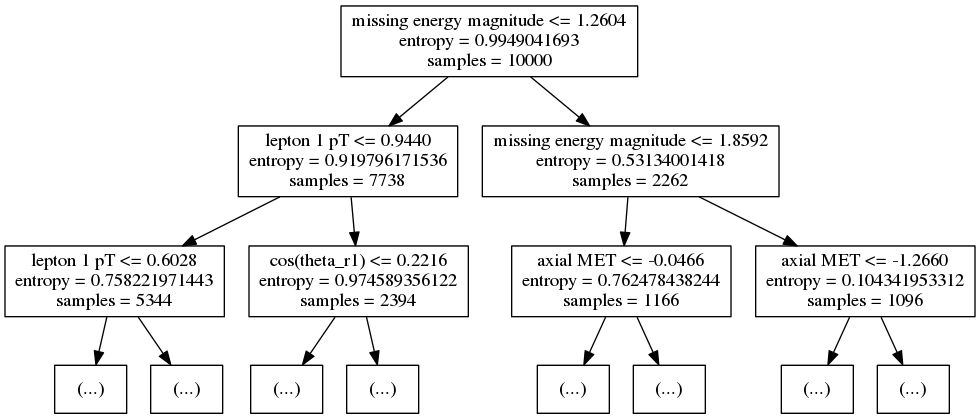

In [29]:
from sklearn.tree import export_graphviz
export_graphviz(clf, out_file="tree.dot", 
                feature_names=df.columns[1:], max_depth=2)
!dot -Tpng -o tree.png tree.dot
from IPython.display import Image
Image("tree.png")

# Model evaluation and selection

## Evaluation

In [120]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
clf = DecisionTreeClassifier(criterion="entropy").fit(X_train, y_train)
print("Training accuracy =", clf.score(X_train, y_train))   # Biased estimate
print("Test accuracy =", clf.score(X_test, y_test))         # Unbiased estimate

Training accuracy = 1.0
Test accuracy = 0.7056



Beware of bias when you estimate model performance:
- Training score is often an optimistic approximate of the true performance;
- The same data should not be used both for training and evaluation.

When ${\cal L}$ is small, prefer cross-validation instead of train-test split for more accurate estimates.

In [101]:
from sklearn.cross_validation import KFold
scores = []

for train, test in KFold(n=len(X), n_folds=5, random_state=42):
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    clf = DecisionTreeClassifier(criterion="entropy", random_state=1).fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

print("%f +-%f" % (np.mean(scores), np.std(scores)))

0.704500 +-0.006804


In [102]:
# Shortcut
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(DecisionTreeClassifier(criterion="entropy", random_state=1), X, y, 
                         cv=KFold(n=len(X), n_folds=5, random_state=42), scoring="accuracy")
print("%f +-%f" % (np.mean(scores), np.std(scores)))

0.704500 +-0.006804


## Under- and over-fitting

- Under-fitting: the model is too simple and does not capture the true relation between X and Y.
- Over-fitting: the model is too specific to the training set and does not generalize.

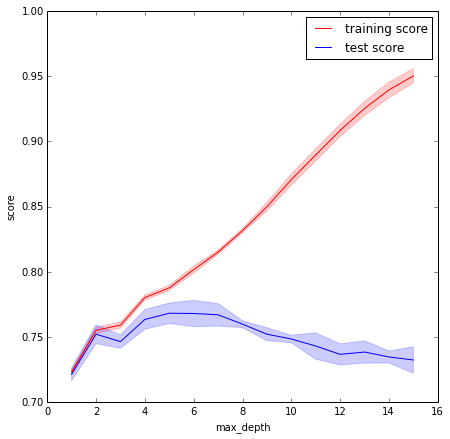

In [95]:
from sklearn.learning_curve import validation_curve

param_range = range(1, 16)
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(), X, y, 
    param_name="max_depth", 
    param_range=param_range, cv=5, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.xlabel("max_depth")
plt.ylabel("score")
plt.plot(param_range, train_scores_mean, color="red", label="training score")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="red")
plt.plot(param_range, test_scores_mean, color="blue", label="test score")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="blue")
plt.legend(loc="best")

In [103]:
# Best trade-off
print("max_depth = %f, accuracy = %f" % (param_range[np.argmax(test_scores_mean)],
                                         np.max(test_scores_mean)))

max_depth = 5.000000, accuracy = 0.768100


## Parameter search

- Finding good hyper-parameters is crucial to control under and overfitting and to achieve better performance.
- This is automatized with the `GridSearchCV` estimator.

In [110]:
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(),
                    param_grid={"max_depth": range(1, 16),
                                "criterion": ["gini", "entropy"],
                                "min_samples_leaf": [1, 5, 10, 50, 100, 500]},
                    scoring="accuracy",
                    cv=5, n_jobs=-1)
grid.fit(X, y)

# Warning: don't report these numbers in your experiments!
print("Best score = %f, Best parameters = %s" % (grid.best_score_, grid.best_params_))

Best score = 0.772900, Best parameters = {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 50}


## Selection and evaluation, simultaneously

- The resulting `grid.best_estimator_` model is not independent from `grid.best_score_` since its construction was guided by the maximization of this quantity. 

- As a result, the optimized `grid.best_score_` accuracy is in fact a biased, optimistic, estimate of the true performance of the model. 

In [111]:
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

scores = cross_val_score(
            GridSearchCV(DecisionTreeClassifier(),
                         param_grid={"max_depth": range(1, 16),
                                     "criterion": ["gini", "entropy"],
                                     "min_samples_leaf": [1, 5, 10, 50, 100, 500]},
                         scoring="accuracy",
                         cv=5, n_jobs=-1), 
            X, y, cv=5, scoring="accuracy")

# Unbiased estimate of the accuracy
print("%f +-%f" % (np.mean(scores), np.std(scores)))

/home/gilles/src/scikit-learn/sklearn/grid_search.py:370: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


0.770200 +-0.005537


# Ensemble methods

## Random Forests

- Single decision trees suffer from high variance. 
- This can be fixed by combining several randomized trees into a single model. 
- From the bias-variance decomposition, it can be shown that the resulting generalization performance is better.

<center>
    <img src="img/forest.png" />
</center>

Randomization:
1. Bootstrap samples
2. Random selection of $K$ split features
3. Random selection of cut-off threshold

Note: 1+2 = `RandomForestClassifier` ; 2+3 = `ExtraTreesClassifier`

In [57]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)
print("Training accuracy =", rf.score(X_train, y_train)) 
print("Test accuracy =", rf.score(X_test, y_test))   

Training accuracy = 1.0
Test accuracy = 0.8036


## Variable importances

- Scores derived from an ensemble of trees to assess the individual importance of input features.
- Can be accessed through the `feature_importances_` attribute of tree-based estimators.

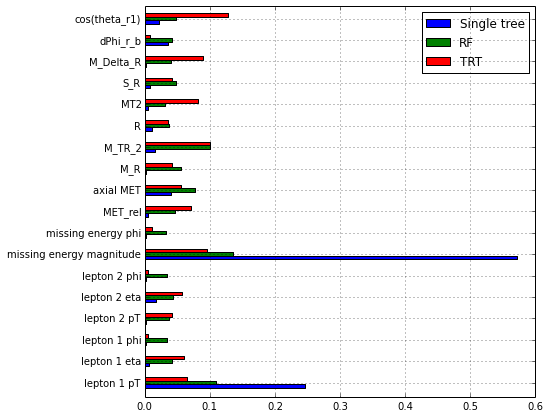

In [154]:
# Feature importances from totally randomized trees (TRT)
from sklearn.ensemble import ExtraTreesClassifier
trt = ExtraTreesClassifier(n_estimators=1000, max_features=1, max_depth=3).fit(X_train, y_train)      

# Plot importances
feature_names = df.columns[1:]

importances = pd.DataFrame()
importances["Single tree"] = pd.Series(grid.best_estimator_.feature_importances_,
                                       index=feature_names)
importances["RF"] = pd.Series(rf.feature_importances_, index=feature_names)
importances["TRT"] = pd.Series(trt.feature_importances_, index=feature_names)
importances.plot(kind="barh")

Disclaimer: Importances are measured only through the eyes of the model. _They may not tell the entire nor the same story!_
    

## Partial dependence plots

Relation between the response Y and a subset of features, marginalized over all other features.

(<matplotlib.figure.Figure at 0x7f2aa4c7a990>,
 [<matplotlib.axes.AxesSubplot at 0x7f2a9dc96750>])

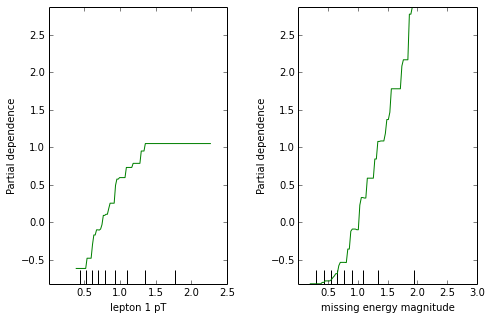

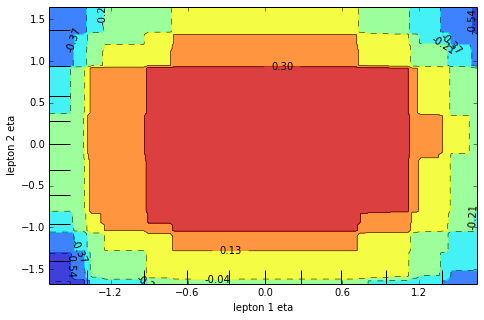

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence

gbrt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_leaf_nodes=5)
gbrt.fit(X, y)

plot_partial_dependence(gbrt, X, feature_names=feature_names, features=[0, 6])
plot_partial_dependence(gbrt, X, feature_names=feature_names, features=[(1, 4)])

More detailed information can be found <a href="http://scikit-learn.org/dev/modules/ensemble.html#partial-dependence">here</a>.

# Model persistence

- As any Python objects, estimators can be saved into files using `pickle` for future reuse. 

In [72]:
clf = DecisionTreeClassifier().fit(X_train, y_train)

# Save to disk
import pickle
pickle.dump(clf, open("my-model.dat", "w"))

# Load from disk
pickle.load(open("my-model.dat"))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

# Going further

- <a href="http://scikit-learn.org/stable/documentation.html">Scikit-Learn documentation</a>
- <a href="http://scikit-learn.org/stable/auto_examples/index.html">Scikit-Learn example gallery</a>
- PyCon 2015 tutorial: Parts <a href="https://www.youtube.com/watch?v=L7R4HUQ-eQ0">1</a> and <a href="https://www.youtube.com/watch?v=oGqGxvqA9-k">2</a>
- Complementary packages: <a href="http://statsmodels.sourceforge.net/">statsmodel</a>, <a href="http://dan.iel.fm/emcee/current/">emcee</a>, <a href="http://www.nltk.org/">NLTK</a>, <a href="http://deeplearning.net/software/theano/">Theano</a>, <a href="https://github.com/lisa-lab/pylearn2">Pylearn2</a>, ...

# Questions?